In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import os
os.chdir('/home/lawrence/Personal/Masters/COMP0087_ Natural_Language_Processing/Project/Data')

# (Hyper)parameters

In [9]:
n_features = 1000
n_components = 10
n_top_words = 20

# Load Data

In [10]:
f = open("bds_1.txt", "r")
f_lines = f.readlines()
f.close()

In [11]:
company_ids = f_lines[0::2]
company_descriptions = f_lines[1::2]

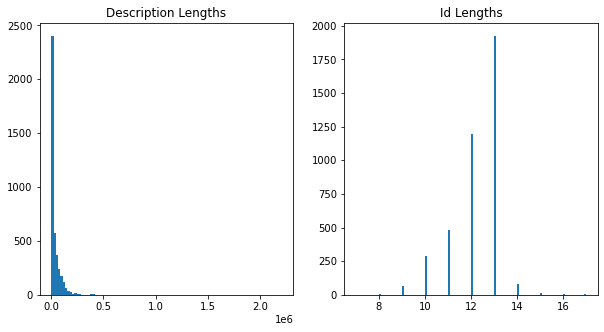

In [12]:
len_descriptions = [len(x) for x in company_descriptions]
plt.figure(figsize=[10, 5])
plt.subplot(1, 2, 1)
plt.hist(len_descriptions, bins=100);
plt.title('Description Lengths');

plt.subplot(1, 2, 2)
plt.hist([len(x) for x in company_ids], bins=100);
plt.title('Id Lengths');

In [25]:
valid_descriptions = np.array(len_descriptions) > 3000
n_samples = np.sum(valid_descriptions)
n_samples

2009

In [26]:
company_ids = np.array(company_ids)[valid_descriptions]
company_descriptions = [x for x in company_descriptions if len(x) > 3000]

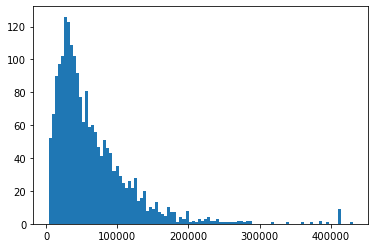

In [28]:
some_lengths = [len(x) for x in company_descriptions if len(x) < 5e5]
plt.hist(some_lengths, bins=100);

# Feature Extraction via Term Frequency
This handles special characters, takes lowercase and removes common words.

In [8]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(company_descriptions)

In [9]:
tf.shape

(2034, 1000)

# Fitting LDA
Online LDA using VB. Really fast!
If there are W words in dictionary, D documents in corpus and K topics then it learns:
 - a matrix K $\times$ W of word probabilities per topic that allow you to determine what the topics mean
 - a matrix D $\times$ K of topic probabilities per document that allows you to cluster documents

In [10]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

In [11]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

In [12]:
lda.perplexity(tf)

498.8016208217857

# What do the Topics Mean?

In [13]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(15, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

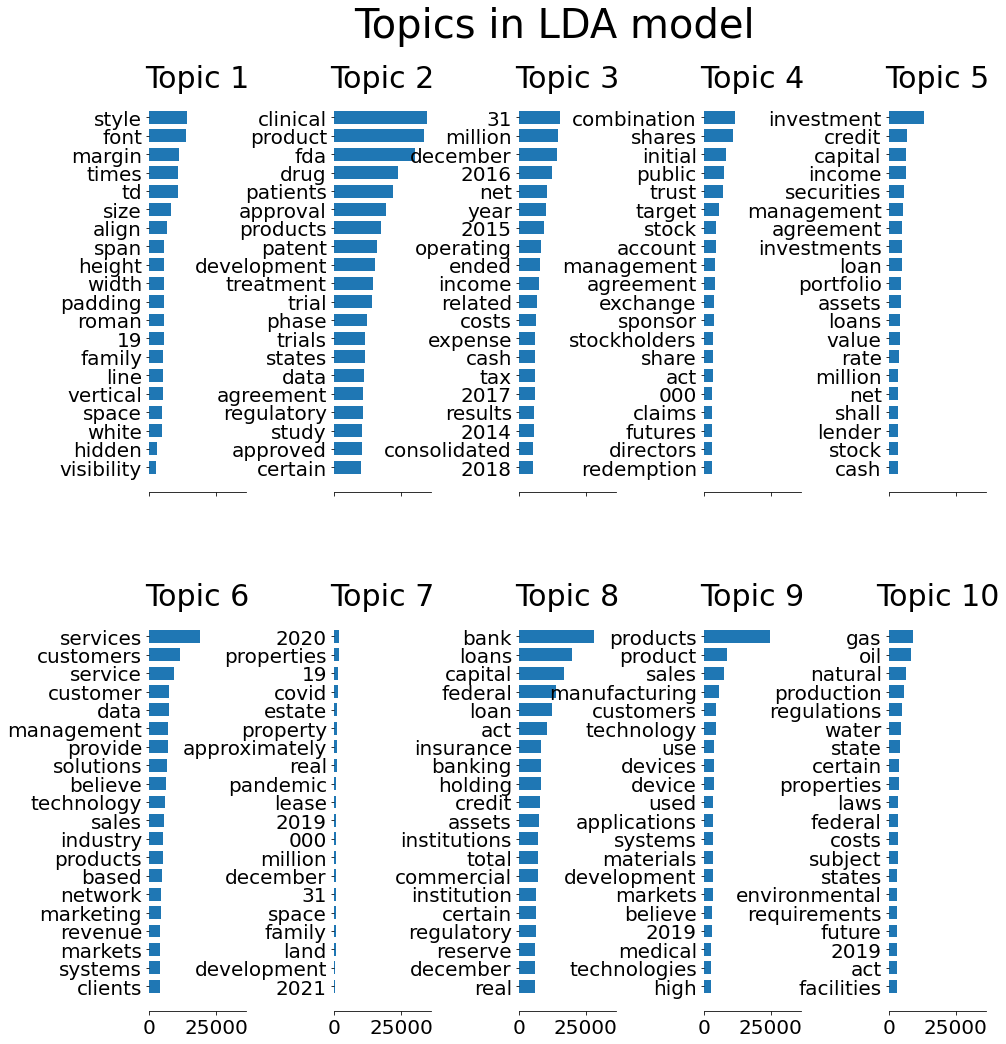

In [14]:
# names of words 
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

# Assigining Topics to Companies

In [15]:
# Produce a companies by topics matrix of prob of each topic by company
topics_companies = lda.transform(tf)

In [16]:
primary_topics = np.argmax(topics_companies, axis=1)

Picking out companies in topic 1 i.e. pharma

In [17]:
topic_id = 1
topic_locs = np.argwhere(primary_topics==topic_id)

this_ind = 5
print(company_ids[topic_locs[this_ind]])

['GTHA:1017110\n']


In [18]:
print(company_descriptions[int(topic_locs[this_ind])])

Business Overview We are a biotechnology company dedicated to eradicate “cross-over” (zoonotic) diseases such as Johne’s disease, Mad Cow Disease, Chronic Wasting Disease, and E.coli. by applying the latest molecular technologies. Diseases of terrestrial, avian and aquatic life animals influence a number of economic and global security issues, including food for an increasing world population, access to international trade, species conservation and protection of those endangered, and economic growth in developing and re-organizing nations. Because many animal disease agents are zoonotic (transmissible between humans and animals, causing infection in both species), their management and prevention are crucial to improving public health on a global scale. We focus on developing molecular diagnostic tests, therapeutics, and vaccines through robotic technology in the belief that better technologies and methodology need to be implemented to help control emerging diseases in animals and in hu

Now topic 9 oil & gas

In [19]:
topic_id = 9
topic_locs = np.argwhere(primary_topics==topic_id)

this_ind = 5
print(company_ids[topic_locs[this_ind]])

['BSIC:10254\n']


In [20]:
print(company_descriptions[int(topic_locs[this_ind])])

Overview Earthstone Energy, Inc., a Delaware corporation (together with our consolidated subsidiaries, the “Company,” “our,” “we,” “us,” “Earthstone” or similar terms), is a growth-oriented independent oil and gas company engaged in the acquisition and development of oil and gas reserves through activities that include the acquisition, drilling and development of undeveloped leases, asset and corporate acquisitions and mergers and, to a lesser extent, exploration activities. Our operations are all in the upstream segment of the oil and natural gas industry and all our properties are onshore in the United States. At present, our primary assets are located in the Midland Basin of west Texas and the Eagle Ford Trend of south Texas. Historically, we have operated in multiple basins in order to enable us to benefit from regional differences in realized prices and the availability and cost of equipment and services. Starting in May 2017, with the closing of the Bold Transaction (more fully d

Now topic 6 ... REITS. Note how high up COVID is in this description and consider its impact on companies that lease office or retail space.

In [21]:
topic_id = 6
topic_locs = np.argwhere(primary_topics==topic_id)

this_ind = 5
print(company_ids[topic_locs[this_ind]])

['AMB:1045610\n']


In [22]:
print(company_descriptions[int(topic_locs[this_ind])])

Prologis, Inc. is a self-administered and self-managed REIT and is the sole general partner of Prologis, L.P. through which it holds substantially all of its assets. We operate Prologis, Inc. and Prologis, L.P. as one enterprise and, therefore, our discussion and analysis refers to Prologis, Inc. and its consolidated subsidiaries, including Prologis, L.P. We invest in real estate through wholly owned subsidiaries and other entities through which we co-invest with partners and investors. We have a significant ownership interest in the co-investment ventures, which may be consolidated or unconsolidated based on our level of control of the entity. Prologis, Inc. began operating as a fully integrated real estate company in 1997 and elected to be taxed as a REIT under the Internal Revenue Code of 1986, as amended (“Internal Revenue Code” or “IRC”). We believe the current organization and method of operation will enable Prologis, Inc. to maintain its status as a REIT. Prologis, L.P. was also

In [23]:
this_ind = 10
# prison REIT lol
print(company_descriptions[int(topic_locs[this_ind])])

Overview We are a diversified government solutions company with the scale and experience needed to solve tough government challenges in flexible, cost-effective ways. Through three segments, CoreCivic Safety, CoreCivic Community, and CoreCivic Properties, we provide a broad range of solutions to government partners that serve the public good through corrections and detention management, a network of residential reentry centers to help address America's recidivism crisis, and government real estate solutions. We have been a flexible and dependable partner for government for more than 35 years. Our employees are driven by a deep sense of service, high standards of professionalism and a responsibility to help government better the public good. We are the nation's largest owner of partnership correctional, detention, and residential reentry facilities and one of the largest prison operators in the United States. We also believe we are the largest private owner of real estate used by U.S. g

# Visualising Clusters

In [24]:
val, vec = np.linalg.eig(topics_companies.T @ topics_companies)
projection_01 = topics_companies @ vec[:, 0:2]
projection_12 = topics_companies @ vec[:, 1:3]
projection_23 = topics_companies @ vec[:, 2:4]
projection_34 = topics_companies @ vec[:, 3:5]

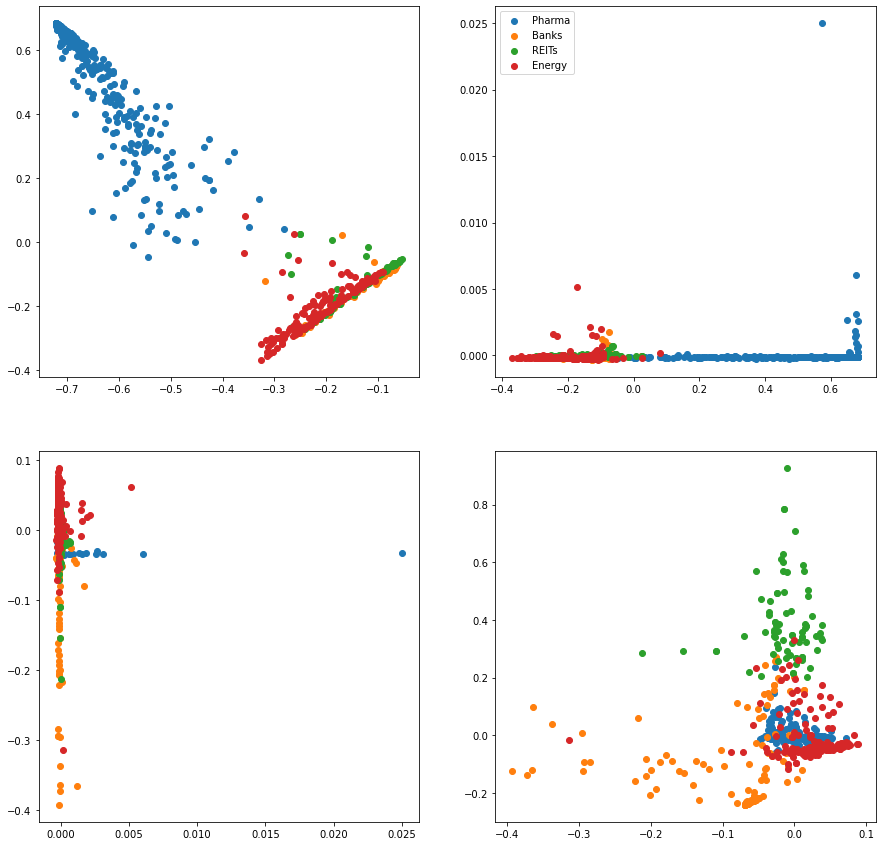

In [25]:
plt.figure(figsize=[15, 15])
plt.subplot(2, 2, 1)
plt.scatter(projection_01[primary_topics==1, :][:, 0], projection_01[primary_topics==1, :][:, 1])
plt.scatter(projection_01[primary_topics==4, :][:, 0], projection_01[primary_topics==4, :][:, 1])
plt.scatter(projection_01[primary_topics==6, :][:, 0], projection_01[primary_topics==6, :][:, 1])
plt.scatter(projection_01[primary_topics==9, :][:, 0], projection_01[primary_topics==9, :][:, 1])

plt.subplot(2, 2, 2)
plt.scatter(projection_12[primary_topics==1, :][:, 0], projection_12[primary_topics==1, :][:, 1])
plt.scatter(projection_12[primary_topics==4, :][:, 0], projection_12[primary_topics==4, :][:, 1])
plt.scatter(projection_12[primary_topics==6, :][:, 0], projection_12[primary_topics==6, :][:, 1])
plt.scatter(projection_12[primary_topics==9, :][:, 0], projection_12[primary_topics==9, :][:, 1])
plt.legend(['Pharma', 'Banks', 'REITs', 'Energy'])

plt.subplot(2, 2, 3)
plt.scatter(projection_23[primary_topics==1, :][:, 0], projection_23[primary_topics==1, :][:, 1])
plt.scatter(projection_23[primary_topics==4, :][:, 0], projection_23[primary_topics==4, :][:, 1])
plt.scatter(projection_23[primary_topics==6, :][:, 0], projection_23[primary_topics==6, :][:, 1])
plt.scatter(projection_23[primary_topics==9, :][:, 0], projection_23[primary_topics==9, :][:, 1])

plt.subplot(2, 2, 4)
plt.scatter(projection_34[primary_topics==1, :][:, 0], projection_34[primary_topics==1, :][:, 1])
plt.scatter(projection_34[primary_topics==4, :][:, 0], projection_34[primary_topics==4, :][:, 1])
plt.scatter(projection_34[primary_topics==6, :][:, 0], projection_34[primary_topics==6, :][:, 1])
plt.scatter(projection_34[primary_topics==9, :][:, 0], projection_34[primary_topics==9, :][:, 1])

# Visualising the Network

In [26]:
sub_select = np.zeros(len(topics_companies), dtype=bool)
sub_select[:50] = True

In [27]:
adj_matrix = topics_companies[sub_select, :] @ topics_companies[sub_select, :].T

In [28]:
np.fill_diagonal(adj_matrix, 1)
am_cut = 0.2
adj_matrix[adj_matrix < am_cut] = 0
adj_matrix[adj_matrix >= am_cut] = 1

In [29]:
G = nx.from_numpy_matrix(adj_matrix)
these_names = company_ids[sub_select]
node_mapping = {i: x for i, x in enumerate(these_names)}
G = nx.relabel_nodes(G, node_mapping)

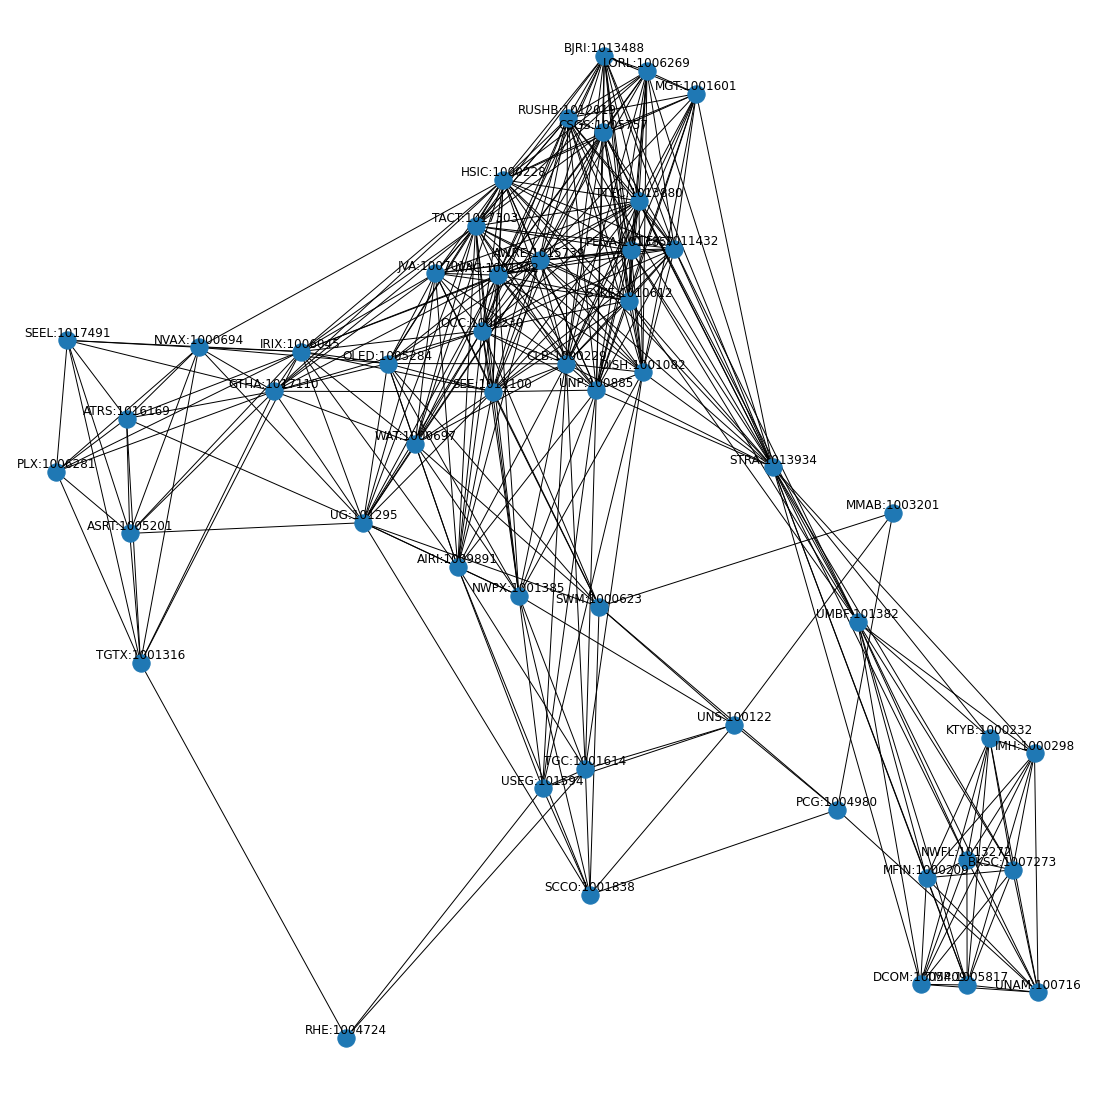

In [30]:
plt.figure(figsize=[15, 15])
nx.draw(G, with_labels=True)